Begun 2/3/25

Analyzing results from running 16 test f090 maps with w2w4 and an ell range of 1000-3000 (bin width 200)

Results are in angle_calc_1738622006

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from pixell import enmap, enplot, reproject, utils, curvedsky
from tqdm import tqdm
import pandas as pd
import nawrapper as nw
import yaml
import time
import healpy as hp
from scipy import optimize as op
import os
from scipy.stats.distributions import chi2
from itertools import combinations

In [2]:
# Loading spectra from run
spectra_dict = np.load('/home/zbh5/act_analysis/act_axion_analysis/results/angle_calc_1738622006/angle_calc_1738622006_spectra.npy',allow_pickle=True).item()

In [3]:
maps = np.array(list(spectra_dict.keys()))
n_maps = len(maps)
print(n_maps)
print(spectra_dict[maps[0]].keys())

16
dict_keys(['ell', 'E1xB2', 'E2xB1', 'E1xE1', 'B2xB2', 'E2xE2', 'B1xB1', 'E1xE2', 'B1xB2', 'E1xB1', 'E2xB2', 'binned_nu', 'estimator', 'covariance', 'CAMB_EE', 'CAMB_BB', 'w2_depth1', 'w2_cross', 'w2_ref', 'fsky', 'w2w4_depth1', 'w2w4_cross', 'w2w4_ref', 'meas_angle', 'meas_errbar', 'initial_timestamp', 'median_timestamp', 'ivar_sum', 'residual_mean', 'residual_sum', 'map_cut'])


In [4]:
ivar_sums = np.zeros(n_maps)
residual_sums = np.zeros(n_maps)
all_errbars = np.zeros(n_maps)
for i in range(n_maps):
    ivar_sums[i] = spectra_dict[maps[i]]['ivar_sum']
    residual_sums[i] = np.abs(spectra_dict[maps[i]]['residual_sum'])
    all_errbars[i] = np.abs(spectra_dict[maps[i]]['meas_errbar'])
    
print(np.where(residual_sums==9999)[0])   # Maps cut by galaxy mask
print(np.where(all_errbars<0.5)[0])       # Maps where curve_fit failed

[]
[]


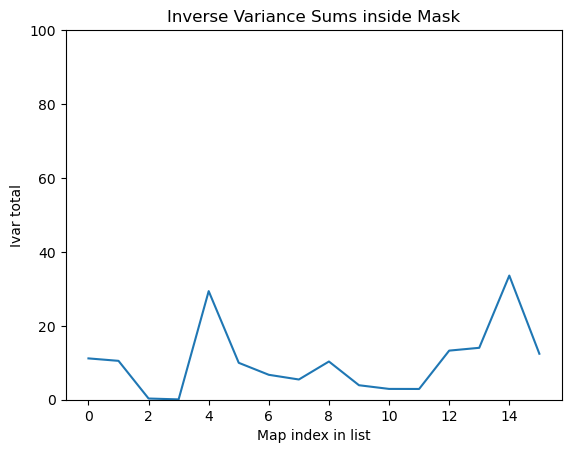

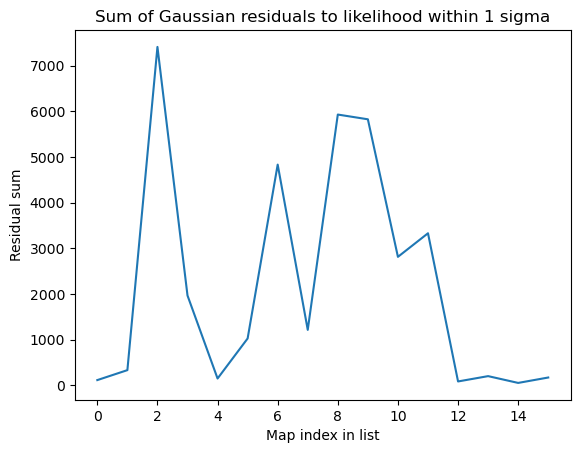

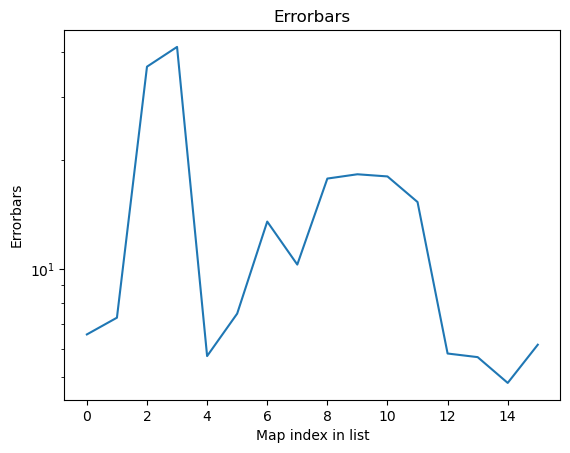

In [5]:
plt.plot(ivar_sums)
plt.ylim(0,100)
plt.title("Inverse Variance Sums inside Mask")
plt.ylabel("Ivar total")
plt.xlabel("Map index in list")
plt.show()
plt.close()
plt.plot(residual_sums)
plt.title("Sum of Gaussian residuals to likelihood within 1 sigma")
plt.ylabel("Residual sum")
plt.xlabel("Map index in list")
plt.show()
plt.close()
plt.semilogy(all_errbars)
plt.title("Errorbars")
plt.ylabel("Errorbars")
plt.xlabel("Map index in list")
plt.show()
plt.close()

In [6]:
# List of indices from looking at likelihoods by eye
very_good = [0,1,4,12,13,14,15]
good = []
borderline = [5,7,10]
bad = [2,3,6,8,9,11]
cut = []
bad_fits = [] 
print(len(very_good), len(good), len(borderline), len(bad), len(cut), len(bad_fits))
all_good = np.sort(very_good+good)
all_bad = np.sort(bad+cut)
all_not_cut = very_good+good+borderline+bad

7 0 3 6 0 0


205
10.350000000000003
Fraction of good maps cut at index with all bad cut:  0.0
Fraction borderline cut at index with all bad cut:  1.0


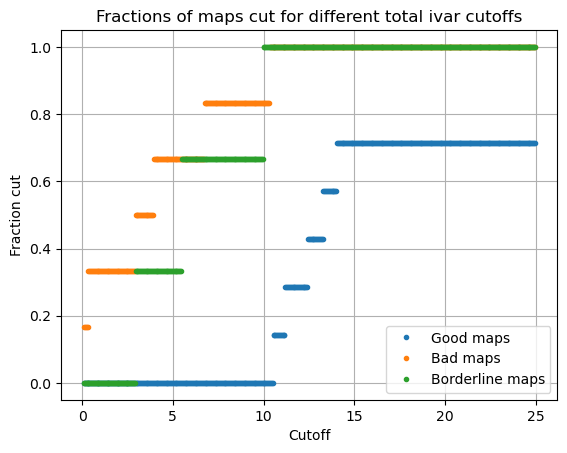

In [7]:
# Iterating over different ivar cutoffs to examine fraction that is cut
good_fractions_cut = []
bad_fractions_cut = []
border_fractions_cut = []
bad_fits_cut = []
cutoffs = np.arange(0.1,25.0,0.05)
for cutoff in cutoffs:
    in_good = 0
    in_bad = 0
    in_border = 0
    in_bad_fits = 0
    outlier_indices_ivar_sums = np.where(ivar_sums < cutoff)[0]
    #print(outlier_indices_ivar_sums)
    num_outlier = len(outlier_indices_ivar_sums)
    for i in range(num_outlier):
        if outlier_indices_ivar_sums[i] in all_good: in_good += 1
        elif outlier_indices_ivar_sums[i] in all_bad: in_bad += 1
        elif outlier_indices_ivar_sums[i] in borderline: in_border += 1
        elif outlier_indices_ivar_sums[i] in bad_fits: in_bad_fits += 1
        else: print("index " + str(i) + " not in any list")
    good_fractions_cut.append(in_good/len(all_good))
    bad_fractions_cut.append(in_bad/len(all_bad))
    border_fractions_cut.append(in_border/len(borderline))

bad_fractions_cut = np.array(bad_fractions_cut)
# Finding the index at which all the bad maps are cut
index_all_bad_cut = np.where(bad_fractions_cut == 1.0)[0][0]
print(index_all_bad_cut)
print(cutoffs[index_all_bad_cut])
print("Fraction of good maps cut at index with all bad cut: ", good_fractions_cut[index_all_bad_cut])
print("Fraction borderline cut at index with all bad cut: ", border_fractions_cut[index_all_bad_cut])
    
plt.plot(cutoffs, good_fractions_cut, '.', label="Good maps")
plt.plot(cutoffs, bad_fractions_cut, '.', label="Bad maps")
plt.plot(cutoffs, border_fractions_cut, '.', label="Borderline maps")
plt.legend()
plt.title("Fractions of maps cut for different total ivar cutoffs")
plt.xlabel("Cutoff")
plt.ylabel("Fraction cut")
plt.grid()
plt.show()
plt.close()

207
1965
Fraction of good maps cut at index with all bad cut:  0.0
Fraction borderline cut at index with all bad cut:  0.3333333333333333


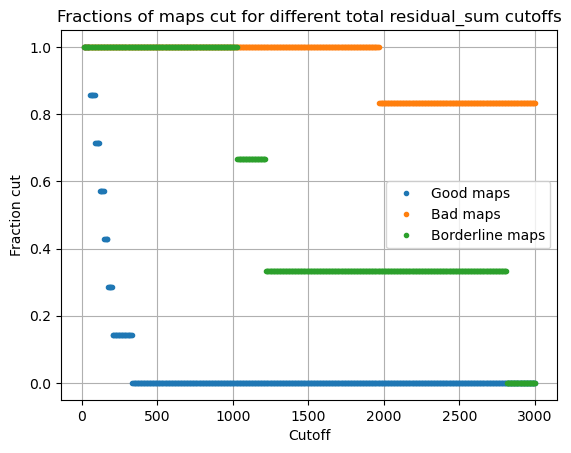

In [8]:
# Iterating over different cutoffs of residual_sums to examine fraction that is cut
# List of indices from looking at likelihoods by eye
good_fractions_cut = []
bad_fractions_cut = []
border_fractions_cut = []
bad_fits_cut = []
cutoffs = np.arange(3000,10,-5) # Want to cut big values
for cutoff in cutoffs:
    in_good = 0
    in_bad = 0
    in_border = 0
    in_bad_fits = 0
    outlier_indices_residual_sums = np.where(residual_sums > cutoff)[0]
    #print(outlier_indices_residual_sums)
    num_outlier = len(outlier_indices_residual_sums)
    for i in range(num_outlier):
        if outlier_indices_residual_sums[i] in all_good: in_good += 1
        elif outlier_indices_residual_sums[i] in all_bad: in_bad += 1
        elif outlier_indices_residual_sums[i] in borderline: in_border += 1
        elif outlier_indices_ivar_sums[i] in bad_fits: in_bad_fits += 1
        else: print("index " + str(i) + " not in any list")
    good_fractions_cut.append(in_good/len(all_good))
    bad_fractions_cut.append(in_bad/len(all_bad))
    border_fractions_cut.append(in_border/len(borderline))

bad_fractions_cut = np.array(bad_fractions_cut)
# Finding the index at which all the bad maps are cut
index_all_bad_cut = np.where(bad_fractions_cut == 1.0)[0][0]
print(index_all_bad_cut)
print(cutoffs[index_all_bad_cut])
print("Fraction of good maps cut at index with all bad cut: ", good_fractions_cut[index_all_bad_cut])
print("Fraction borderline cut at index with all bad cut: ", border_fractions_cut[index_all_bad_cut])
    
plt.plot(cutoffs, good_fractions_cut, '.', label="Good maps")
plt.plot(cutoffs, bad_fractions_cut, '.', label="Bad maps")
plt.plot(cutoffs, border_fractions_cut, '.', label="Borderline maps")
plt.legend()
plt.title("Fractions of maps cut for different total residual_sum cutoffs")
plt.xlabel("Cutoff")
plt.ylabel("Fraction cut")
plt.grid()
plt.show()
plt.close()


0
3000
Fraction of good maps cut at index with all bad cut:  0.0
Fraction borderline cut at index with all bad cut:  0.3333333333333333


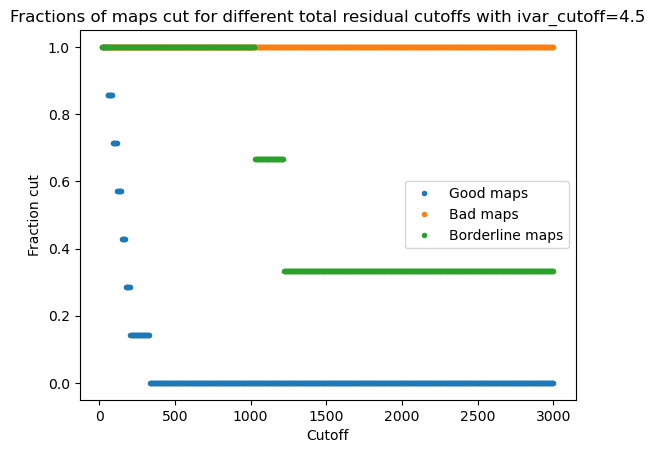

In [9]:
# Testing fixing the ivar cut and then sweeping out residual cut
good_fractions_cut = []
bad_fractions_cut = []
border_fractions_cut = []
bad_fits_cut = []
ivar_cutoff = 4.5
cutoffs = np.arange(3000,15,-5)
for cutoff in cutoffs:
    in_good = 0
    in_bad = 0
    in_border = 0
    in_bad_fits = 0
    outlier_indices_ivar_sums = np.where(ivar_sums < ivar_cutoff)[0]
    outlier_indices_residual_sums = np.where(residual_sums > cutoff)[0]
    #print(outlier_indices_ivar_sums)
    outlier_union = np.union1d(outlier_indices_residual_sums,outlier_indices_ivar_sums)
    num_outlier = len(outlier_union)
    for i in range(num_outlier):
        if outlier_union[i] in all_good: in_good += 1
        elif outlier_union[i] in all_bad: in_bad += 1
        elif outlier_union[i] in borderline: in_border += 1
        elif outlier_union[i] in bad_fits: in_bad_fits += 1
        else: print("index " + str(i) + " not in any list")
    good_fractions_cut.append(in_good/len(all_good))
    bad_fractions_cut.append(in_bad/len(all_bad))
    border_fractions_cut.append(in_border/len(borderline))

bad_fractions_cut = np.array(bad_fractions_cut)
# Finding the index at which all the bad maps are cut
index_all_bad_cut = np.where(bad_fractions_cut == 1.0)[0][0]
print(index_all_bad_cut)
print(cutoffs[index_all_bad_cut])
print("Fraction of good maps cut at index with all bad cut: ", good_fractions_cut[index_all_bad_cut])
print("Fraction borderline cut at index with all bad cut: ", border_fractions_cut[index_all_bad_cut])
    
plt.plot(cutoffs, good_fractions_cut, '.', label="Good maps")
plt.plot(cutoffs, bad_fractions_cut, '.', label="Bad maps")
plt.plot(cutoffs, border_fractions_cut, '.', label="Borderline maps")
plt.legend()
plt.title("Fractions of maps cut for different total residual cutoffs with ivar_cutoff="+str(ivar_cutoff))
plt.xlabel("Cutoff")
plt.ylabel("Fraction cut")
plt.show()
plt.close()

In [11]:
# Implementing automatic data cuts
cut_flags = np.zeros(n_maps)
ivar_sums = np.zeros(n_maps)
all_errbars = np.zeros(n_maps)
residual_sums = np.zeros(n_maps)
angles_rad = np.zeros(n_maps)
errbars_rad = np.zeros(n_maps)
for i in range(n_maps):
    cut_flags[i] = spectra_dict[maps[i]]['map_cut']
    all_errbars[i] = spectra_dict[maps[i]]['meas_errbar']
    ivar_sums[i] = spectra_dict[maps[i]]['ivar_sum']
    residual_sums[i] = spectra_dict[maps[i]]['residual_sum']
    angles_rad[i] = np.deg2rad(spectra_dict[maps[i]]['meas_angle'])
    errbars_rad[i] = np.deg2rad(spectra_dict[maps[i]]['meas_errbar'])

# Extracting map info and results into separate arrays for ease of access
# Not using numpy arrays at first to more easily put strings and arrays in the list
map_arrays = []
map_timestamps = []
estimators = []
covariances = []
all_e2xe2 = []

for i in range(n_maps):
    map_arrays.append(maps[i].split('_')[2])
    map_timestamps.append(maps[i].split('_')[1])
    estimators.append(spectra_dict[maps[i]]['estimator'])
    covariances.append(spectra_dict[maps[i]]['covariance'])
    all_e2xe2.append(spectra_dict[maps[i]]['E2xE2'])
map_arrays = np.array(map_arrays)
map_timestamps = np.array(map_timestamps)
estimators = np.array(estimators)
covariances = np.array(covariances)
all_e2xe2 = np.array(all_e2xe2)

# Doing cuts
ivar_cutoff = 4.5
residual_cutoff = 1500
    
print("Total number of maps: ", n_maps)
# Identifying maps that weren't cut by the galaxy mask
cut_good = np.where(cut_flags != 1)[0]
print("Maps passing galaxy mask cut: ", len(cut_good))
# Using the super small errorbars to identify the failed fits - there were none in this run
errbar_good = np.where(all_errbars>0.1)[0]
print("Maps passing bad fit cut: ", len(errbar_good))
# Using residual cutoff of 2000 - cuts come from analysis in data_quality_larger_set_corrected_mode_count_20241212.ipynb
residual_good = np.where(residual_sums<residual_cutoff)[0]
print("Maps passing residual cut: ", len(residual_good))
# Using ivar cutoff of 4.0
ivar_good = np.where(ivar_sums>ivar_cutoff)[0]
print("Maps passing ivar cut: ", len(ivar_good))
# Taking the intersection of these four sets to get those maps that pass all cuts
set_pass_all_cuts = np.intersect1d(np.intersect1d(np.intersect1d(cut_good,errbar_good),residual_good),ivar_good)
print("Maps passing all four cuts: ", len(set_pass_all_cuts))
print(set_pass_all_cuts)

Total number of maps:  16
Maps passing galaxy mask cut:  16
Maps passing bad fit cut:  16
Maps passing residual cut:  9
Maps passing ivar cut:  11
Maps passing all four cuts:  9
[ 0  1  4  5  7 12 13 14 15]


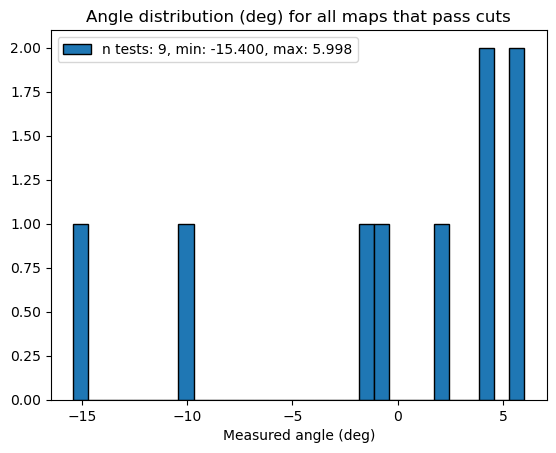

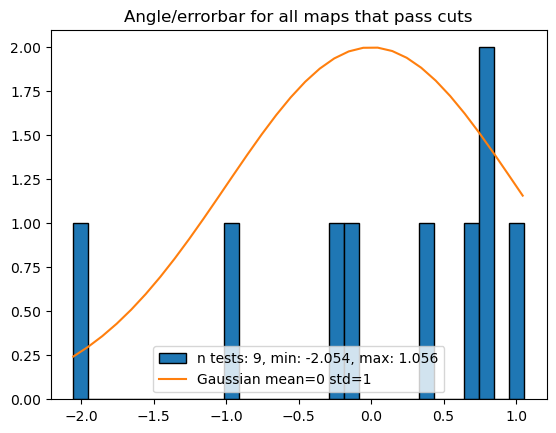

In [12]:
angles_deg = np.rad2deg(angles_rad)
errbars_deg = np.rad2deg(errbars_rad)
plt.hist(angles_deg[set_pass_all_cuts],bins=30, edgecolor='black',
        label=f'n tests: {len(set_pass_all_cuts)}, min: {np.min(angles_deg[set_pass_all_cuts]):.3f}, max: {np.max(angles_deg[set_pass_all_cuts]):.3f}')
plt.title("Angle distribution (deg) for all maps that pass cuts")
plt.xlabel("Measured angle (deg)")
plt.legend()
plt.show()
plt.close()

# The ratio angle/errbar should be normally distributed with std=1
n, bins, _ = plt.hist(angles_deg[set_pass_all_cuts]/errbars_deg[set_pass_all_cuts],bins=30, edgecolor='black',
                     label=f'n tests: {len(set_pass_all_cuts)}, min: {np.min(angles_deg[set_pass_all_cuts]/errbars_deg[set_pass_all_cuts]):.3f}, max: {np.max(angles_deg[set_pass_all_cuts]/errbars_deg[set_pass_all_cuts]):.3f}')
plt.title("Angle/errorbar for all maps that pass cuts")
x = np.arange(np.min(bins),np.max(bins),0.1)
#print(bins)
# assuming mean of zero and std=1
plt.plot(x, np.max(n)*np.exp(-x**2/2),label='Gaussian mean=0 std=1')
plt.legend()
plt.show()
plt.close()

In [15]:
# Checking chi2 for the model fit of estimator-theory for all maps passing cuts 
chi2_good_maps = []
pte_good_maps = []
all_theory_covs = []

test_CAMB_EE = spectra_dict[maps[0]]['CAMB_EE']
ell = spectra_dict[maps[0]]['ell']
bin_size = 200
nu_b = (2*ell+1)*bin_size

for idx in set_pass_all_cuts:
    #null = 1.0*estimators[idx] - all_e2xe2[idx]*np.sin(2*angles_rad[idx])
    null = 1.0*estimators[idx] - test_CAMB_EE*np.sin(2*angles_rad[idx])
    theory_cov = 2*test_CAMB_EE**2 * ((np.sin(2*angles_rad[idx])**2/nu_b)+2*np.cos(2*angles_rad[idx])**2*errbars_rad[idx]**2)
    sum_cov = covariances[idx] + theory_cov
    chi2_good_map = np.sum(null**2/(1.0*sum_cov))
    dof_good_map = null.size - 1 # Should be the same each time
    pte_good_map = chi2.sf(chi2_good_map,dof_good_map)
    chi2_good_maps.append(chi2_good_map)
    pte_good_maps.append(pte_good_map)
    all_theory_covs.append(theory_cov)
chi2_good_maps = np.array(chi2_good_maps)
pte_good_maps = np.array(pte_good_maps)
all_theory_covs = np.array(all_theory_covs)

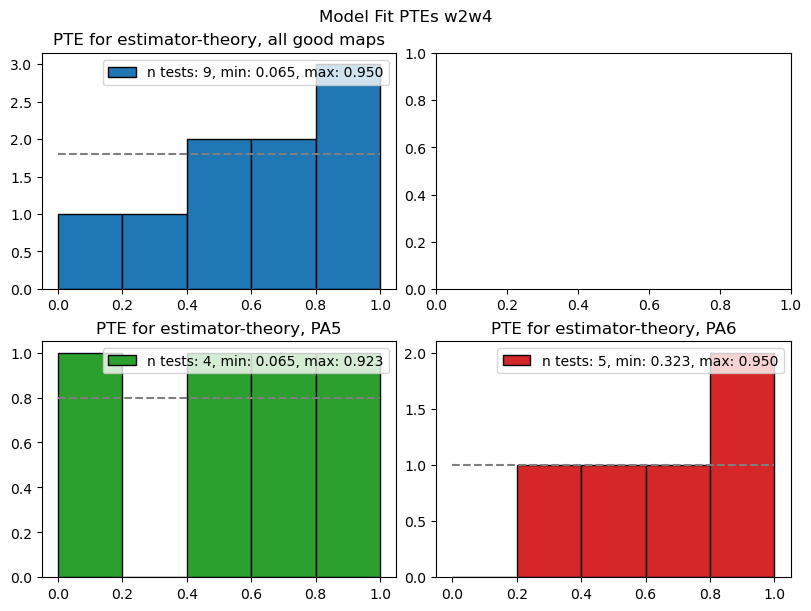

In [18]:
# Making PTE distribution plots 
nbins = 5   # Have been using 10; ACT DR6 papers seem to use 14 for their null tests
fig, axs = plt.subplots(2, 2, constrained_layout=True, figsize=(8,6))
fig.suptitle("Model Fit PTEs w2w4")
# All maps
axs[0,0].hist(pte_good_maps,bins=nbins,range=(0.0,1.0), color='tab:blue', edgecolor='black',
              label=f'n tests: {len(pte_good_maps)}, min: {np.min(pte_good_maps):.3f}, max: {np.max(pte_good_maps):.3f}')
axs[0,0].hlines(len(pte_good_maps)/nbins, 0.0, 1.0, colors='tab:gray', linestyles='dashed')
axs[0,0].set_title("PTE for estimator-theory, all good maps")
axs[0,0].legend()
# pa4
#idx_pa4 = np.where(map_arrays[set_pass_all_cuts]=='pa4')[0]
#axs[0,1].hist(pte_good_maps[idx_pa4], bins=nbins,range=(0.0,1.0), color='tab:orange', edgecolor='black',
#             label=f'n tests: {len(pte_good_maps[idx_pa4])}, min: {np.min(pte_good_maps[idx_pa4]):.3f}, max: {np.max(pte_good_maps[idx_pa4]):.3f}')
#axs[0,1].hlines(len(pte_good_maps[idx_pa4])/nbins, 0.0, 1.0, colors='tab:gray', linestyles='dashed')
#axs[0,1].set_title("PTE for estimator-theory, PA4")
#axs[0,1].legend()
# pa5
idx_pa5 = np.where(map_arrays[set_pass_all_cuts]=='pa5')[0]
axs[1,0].hist(pte_good_maps[idx_pa5], bins=nbins,range=(0.0,1.0), color='tab:green', edgecolor='black',
             label=f'n tests: {len(pte_good_maps[idx_pa5])}, min: {np.min(pte_good_maps[idx_pa5]):.3f}, max: {np.max(pte_good_maps[idx_pa5]):.3f}')
axs[1,0].hlines(len(pte_good_maps[idx_pa5])/nbins, 0.0, 1.0, colors='tab:gray', linestyles='dashed')
axs[1,0].set_title("PTE for estimator-theory, PA5")
axs[1,0].legend()
# pa6
idx_pa6 = np.where(map_arrays[set_pass_all_cuts]=='pa6')[0]
axs[1,1].hist(pte_good_maps[idx_pa6], bins=nbins,range=(0.0,1.0), color='tab:red', edgecolor='black',
             label=f'n tests: {len(pte_good_maps[idx_pa6])}, min: {np.min(pte_good_maps[idx_pa6]):.3f}, max: {np.max(pte_good_maps[idx_pa6]):.3f}')
axs[1,1].hlines(len(pte_good_maps[idx_pa6])/nbins, 0.0, 1.0, colors='tab:gray', linestyles='dashed')
axs[1,1].set_title("PTE for estimator-theory, PA6")
axs[1,1].legend()
plt.show()
plt.close()